# COVID-19 Daily State Tracking

This Juptyer Notebook is © 2020 Stacey Adams and is available under the  [MIT License](https://choosealicense.com/licenses/mit/).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

## Set the state you wish to process here

In [2]:
state = 'MO'

### State Abbreviation Table (collapsed by default)

In [3]:
# United States of America Python Dictionary to translate States,
# Districts & Territories to Two-Letter codes and vice versa.
#
# https://gist.github.com/rogerallen/1583593
#
# Dedicated to the public domain.  To the extent possible under law,
# Roger Allen has waived all copyright and related or neighboring
# rights to this code.

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico Commonwealth': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# thank you to @kinghelix and @trevormarburger for this idea
abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))

# build a dataframe for later use
state_abbrev = pd.DataFrame(data=abbrev_us_state.values(), index=abbrev_us_state.keys(), columns=["state name"])
state_abbrev.index.names = ['state']
#state_abbrev.head(5)

def highlight_selected_state(s):
    if s['state name'] == abbrev_us_state[state]:
        return ['background-color: yellow; color: black']*len(s)
    else:
        return ['']*len(s)

## Read the daily state data from covidtracking.com

The COVID Tracking Project data is published under a [Creative Commons CC BY-NC-4.0 license](http://creativecommons.org/licenses/by-nc/4.0/).

In [4]:
pd.set_option("precision", 4)
data_url = "http://covidtracking.com/api/states/daily.csv"
corona = pd.read_csv(data_url, parse_dates=['date'])
corona['testPositivityRate'] = corona['positiveIncrease'] * 100 / corona['totalTestResultsIncrease']
corona.head(5)

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade,testPositivityRate
0,2020-08-06,AK,4223.0,257349.0,NaN,42.0,NaN,NaN,NaN,2.0,...,0,0,cb6042a57c94293675b4f8b2a02af69d8012d91f,0,0,0,0,0,NaN,0.9317
1,2020-08-06,AL,96592.0,643192.0,NaN,1575.0,11313.0,NaN,1211.0,NaN,...,19,213,27774ad0a8fd9899b54fb5d577b1b778d3d5004f,0,0,0,0,0,NaN,15.7254
2,2020-08-06,AR,47028.0,492808.0,NaN,514.0,3118.0,NaN,NaN,111.0,...,7,0,1188e9bb4b25b98410580729c252181b8d1f4dfc,0,0,0,0,0,NaN,14.6269
3,2020-08-06,AS,0.0,1396.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,5c33616b07ca7687fdea8c9ea6a110cb6abea724,0,0,0,0,0,NaN,NaN
4,2020-08-06,AZ,183647.0,812217.0,NaN,1879.0,14068.0,593.0,NaN,427.0,...,70,509,b9e494d4ce7ec7f1188ac5a7b72643b596000d1d,0,0,0,0,0,NaN,13.9895


## Read population data from US Census Bureau

US Census Bureau data is public domain.

In [5]:
population = pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/state/detail/SCPRC-EST2019-18+POP-RES.csv", usecols=['NAME', 'POPESTIMATE2019'])
population.rename(columns={"NAME": "state name", "POPESTIMATE2019": "2019 population estimate"}, inplace=True)
# data missing from url above; manually retrieved from CIA World Factbook (and provided by the US Census Bureau)
islands = pd.DataFrame([
    ['American Samoa', 55_212],
    ['Guam', 168_485],
    ['Northern Mariana Islands', 51_433],
    ['Virgin Islands', 106_235]
], columns=['state name', '2019 population estimate'])
population = population.append(islands)

## Display National and State Totals

In [6]:
national_data = corona.agg({'positiveIncrease' : ['sum'], 'deathIncrease' : ['sum']})
national_data.rename(columns={"positiveIncrease": "total cases", "deathIncrease": "total deaths"}, index={"sum": "United States"}, inplace=True)
national_data.index.names = ['state name']
national_with_pop = pd.merge(national_data, population, on='state name', how='left').set_index('state name')
national_with_pop.index.names = ['']
national_with_pop['cases per 100k pop'] = (national_with_pop['total cases'] * 100_000 / national_with_pop['2019 population estimate']).round(2)
national_with_pop['mortality rate'] = (national_with_pop['total deaths'] * 100 / national_with_pop['total cases']).round(2)
national_with_pop['deaths per 100k pop'] = (national_with_pop['total deaths'] * 100_000 / national_with_pop['2019 population estimate']).round(2)
national_with_pop

,total cases,total deaths,2019 population estimate,cases per 100k pop,mortality rate,deaths per 100k pop
,,,,,,
United States,4852026,151483,328239523,1478.2,3.12,46.15


In [7]:
state_totals = corona.groupby(by="state").sum()
state_totals.rename(columns={"positiveIncrease": "total cases", "deathIncrease": "total deaths"}, inplace=True)
state_totals = pd.merge(state_abbrev, state_totals[["total cases", "total deaths"]], on='state')
state_totals['state'] = state_totals.index
state_with_pop = pd.merge(state_totals, population, on='state name', how='left').set_index('state')
state_with_pop['cases per 100k pop'] = (state_with_pop['total cases'] * 100_000 / state_with_pop['2019 population estimate']).round(2)
state_with_pop['mortality rate'] = (state_with_pop['total deaths'] * 100 / state_with_pop['total cases']).round(2)
state_with_pop['deaths per 100k pop'] = (state_with_pop['total deaths'] * 100_000 / state_with_pop['2019 population estimate']).round(2)
state_with_pop.style.apply(highlight_selected_state, axis=1)

,state name,total cases,total deaths,2019 population estimate,cases per 100k pop,mortality rate,deaths per 100k pop
state,,,,,,,
AL,Alabama,96592,1714,4903185,1969.9800,1.7700,34.9600
AK,Alaska,4223,25,731545,577.2700,0.5900,3.4200
AS,American Samoa,0,0,55212,0.0000,nan,0.0000
AZ,Arizona,183645,4002,7278717,2523.0400,2.1800,54.9800
AR,Arkansas,47028,515,3017804,1558.3500,1.1000,17.0700
CA,California,529927,9869,39512223,1341.1700,1.8600,24.9800
CO,Colorado,48988,1717,5758736,850.6700,3.5000,29.8200
CT,Connecticut,50245,4437,3565287,1409.2800,8.8300,124.4500
DE,Delaware,15365,587,973764,1577.9000,3.8200,60.2800


In [8]:
state_name = abbrev_us_state[state]
state_with_pop.query("`state name`==@state_name")

,state name,total cases,total deaths,2019 population estimate,cases per 100k pop,mortality rate,deaths per 100k pop
state,,,,,,,
MO,Missouri,56383,1280,6137428,918.67,2.27,20.86


## Extract the state data and add 7-day averages

In [9]:
state_data = corona.query("state==@state")
pd.set_option('mode.chained_assignment',None) # don't display the SettingWithCopyWarning triggered by the next lines
state_data['7dayAverage'] = state_data.positiveIncrease.rolling(7).mean().shift(-3)
state_data['7DayAvgDeaths'] = state_data.deathIncrease.rolling(7).mean().shift(-3)
state_data['weeks ago'] = (pd.Timestamp.now() - state_data['date']).dt.days // 7
state_data[['date', 'positiveIncrease', '7dayAverage', 'deathIncrease', '7DayAvgDeaths']].head(5)

,date,positiveIncrease,7dayAverage,deathIncrease,7DayAvgDeaths
26,2020-08-06,1062,NaN,8,NaN
82,2020-08-05,1241,NaN,6,NaN
138,2020-08-04,1193,NaN,11,NaN
194,2020-08-03,1047,1078.4286,2,6.7143
250,2020-08-02,582,1224.4286,0,7.4286


## Calculate Case and Death Count Deltas per Week

A decrease in cases or deaths week over week is indicated as a negative number, and colored green.

An increase in cases or deaths week over week is indicated as a positive number, and colored red.

In [10]:
def color_positive_red(value):
    """
    Colors elements in a dataframe red if positive and green if negative. Does not color NaN.
    """
    if value > 0:
        return 'color: red'
    elif value < 0:
        return 'color: green'
    else:
        return ''

weekly = state_data[['date', 'weeks ago', 'positiveIncrease', 'deathIncrease']].set_index('date').groupby('weeks ago').sum()
weekly.diff(periods=-1).head(5)\
    .rename(columns={"positiveIncrease": "change in cases from previous week", "deathIncrease": "change in deaths from previous week"})\
    .style.applymap(color_positive_red)\
    .format({'change in cases from previous week': '{:.0f}', 'change in deaths from previous week': '{:.0f}'})

,change in cases from previous week,change in deaths from previous week
weeks ago,,
0,-4911,-28
1,2907,8
2,2775,-13
3,2120,45
4,253,-11


## Display a time series plot for Daily Cases

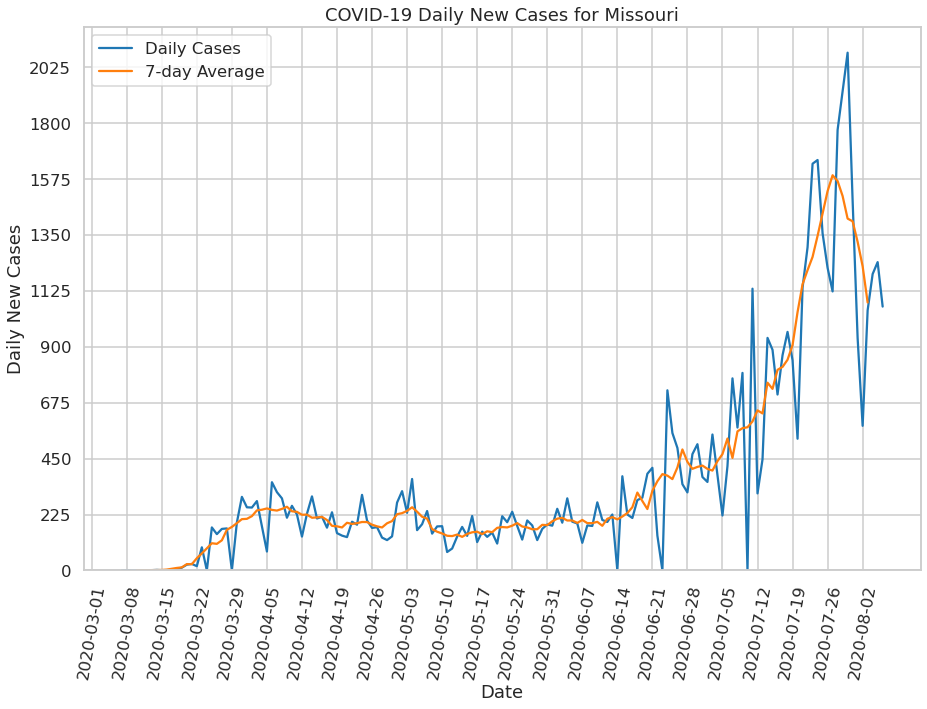

In [11]:
# use plot elements suitable for talks
sns.set_context("talk")
sns.set_style("whitegrid")
# set figure size
plt.figure(figsize=(15,10))
# Time series plot with label
sns.lineplot(x="date", y="positiveIncrease", label="Daily Cases", data=state_data, ci=None)
# 7-day rolling average
sns.lineplot(x="date", y="7dayAverage", label="7-day Average", data=state_data, ci=None)
# set plot elements
plt.title("COVID-19 Daily New Cases for %s" % abbrev_us_state[state])
plt.xlabel("Date")
plt.ylabel("Daily New Cases")
axis = list(plt.axis())
axis[2]=0
plt.axis(axis)
locs, labels = plt.xticks()
plt.xticks(np.arange(locs[0], locs[locs.size-1]+6, 7), rotation=80)
locs, labels = plt.yticks()
plt.yticks(np.arange(0, locs[locs.size-1], locs[locs.size-1] / 10))
plt.show()

## Display a time series plot for Daily Deaths

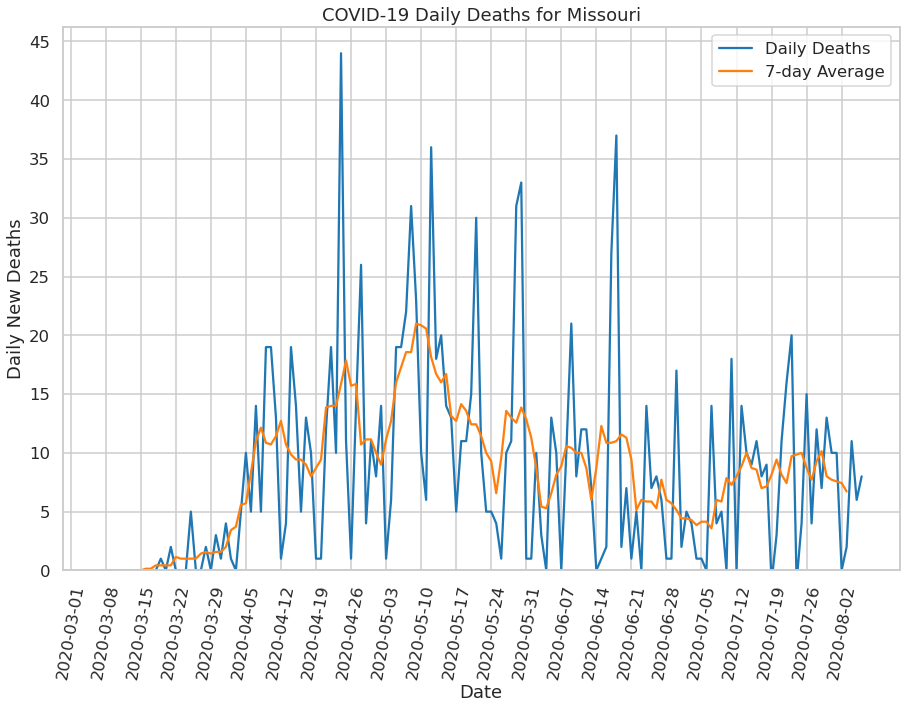

In [12]:
# use plot elements suitable for talks
sns.set_context("talk")
sns.set_style("whitegrid")
# set figure size
plt.figure(figsize=(15,10))
# Time series plot with label
sns.lineplot(x="date", y="deathIncrease", label="Daily Deaths", data=state_data, ci=None)
# 7-day rolling average
sns.lineplot(x="date", y="7DayAvgDeaths", label="7-day Average", data=state_data, ci=None)
# set plot elements
plt.title("COVID-19 Daily Deaths for %s" % abbrev_us_state[state])
plt.xlabel("Date")
plt.ylabel("Daily New Deaths")
axis = list(plt.axis())
axis[2]=0
plt.axis(axis)
locs, labels = plt.xticks()
plt.xticks(np.arange(locs[0], locs[locs.size-1]+6, 7), rotation=80)
locs, labels = plt.yticks()
plt.yticks(np.arange(0, locs[locs.size-1], locs[locs.size-1] / 10))
plt.show()